# Libraries

In [1]:
%pip install biopython

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import Bio

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBParser, PPBuilder
from Bio.PDB.Chain import Chain
from Bio.PDB.internal_coords import *
from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test
from Bio.PDB.SCADIO import write_SCAD
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.Polypeptide import is_aa
from Bio.PDB import NeighborSearch

import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00


In [7]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import preprocessing
import graphconstructor
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


# Setup, utils

In [8]:
# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Define the file for a demo protein structure
# pdb_file = '/content/drive/MyDrive/CAS_AML/datasets/all_nano_structures_single_domain_clean/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = '/content/drive/MyDrive/CAS_AML/datasets/all_nano_structures_single_domain_clean'

# Define the file containing amino acid information
aa_info_file = '/content/drive/MyDrive/CAS_AML/info_files/aa_mass_letter.csv'

In [9]:
# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

# Load, preprocess

In [11]:
from preprocessing import ProteinAnalyzer

# Initialize ProteinAnalyzer
preprocessing = ProteinAnalyzer(pdb_directory=pdb_directory, aa_info_file=aa_info_file)

# Prepare data
try:
    pdb_files = preprocessing.prepare_data()
except Exception as e:
    print(f"Error during data preparation: {e}")


Processing 1646 PDB files...


Processing PDB files: 100%|██████████| 1646/1646 [12:14<00:00,  2.24it/s, Processed=1646]

Prepared data for 1646 PDB files.


In [12]:
from graphconstructor import GraphConstructor

In [ ]:
# To activate when I want to preprocess all structures


# # Initialize the graph constructor
# graphconstructor = GraphConstructor()

# # Example usage with preprocessing output
# dataset = []
# for residues in pdb_files:  # Output from preprocessing.prepare_data()
#     try:
#         graph = graphconstructor.build_graph(residues, distance_threshold=10.0)
#         if graph.x is not None and graph.edge_index.size(1) > 0:
#             dataset.append(graph)
#         else:
#             print(f"Skipped empty graph for residues.")
#     except Exception as e:
#         print(f"Error creating graph: {e}")

# # Initialize DataLoader
# from torch_geometric.loader import DataLoader

# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Print dataset size
# print(f"Dataset size: {len(dataset)} graphs")


# check the code on one sample

In [13]:
# Initialize the graph constructor
graphconstructor = GraphConstructor()

# Example residue list (output from preprocessing)
example_residues = pdb_files[0]  # Assuming pdb_residues is the output from prepare_data()

# Build graph with a loading bar
graph = graphconstructor.build_graph(example_residues, distance_threshold=10.0)

# Check graph details
print(graph)


Computing edges: 100%|██████████| 1335/1335 [00:11<00:00, 112.94it/s]


Data(x=[1335, 25], edge_index=[2, 24858], edge_attr=[24858, 1])


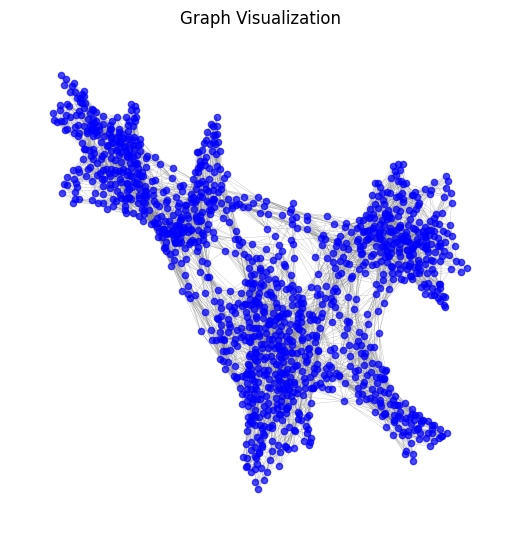

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, node_size=50, edge_width=0.5, figsize=(5, 5)):
    """
    Visualize a PyTorch Geometric graph using NetworkX.

    Args:
        data (Data): PyTorch Geometric Data object.
        node_size (int): Size of the nodes in the plot.
        edge_width (float): Width of the edges in the plot.
        figsize (tuple): Size of the Matplotlib figure.
    """
    # Convert PyTorch Geometric Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Create the plot
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)  # Spring layout for better node spacing
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_size,
        width=edge_width,
        node_color="blue",
        edge_color="gray",
        alpha=0.7,
    )
    plt.title("Graph Visualization")
    plt.show()

# Example usage
visualize_graph(graph, node_size=20, edge_width=0.2, figsize=(5, 5))


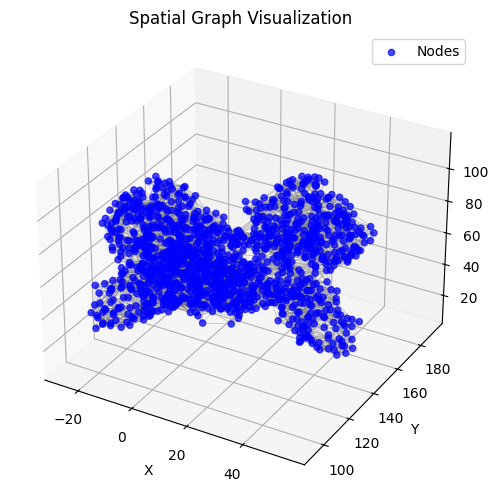

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.utils import to_networkx


def visualize_graph_spatial(data, residues, node_size=50, edge_width=0.5, figsize=(10, 10)):
    """
    Visualize a PyTorch Geometric graph in 3D space using residue coordinates.

    Args:
        data (Data): PyTorch Geometric Data object.
        residues (list): List of residue dictionaries, including coordinates.
        node_size (int): Size of the nodes in the plot.
        edge_width (float): Width of the edges in the plot.
        figsize (tuple): Size of the Matplotlib figure.
    """
    # Convert PyTorch Geometric Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Extract spatial positions from residues
    coords = [residue["coord"] for residue in residues]  # List of [x, y, z] positions

    # Create 3D scatter plot for the graph
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Draw nodes using 3D coordinates
    x_nodes, y_nodes, z_nodes = zip(*coords)  # Unpack coordinates
    ax.scatter(x_nodes, y_nodes, z_nodes, s=node_size, c='blue', alpha=0.7, label="Nodes")

    # Draw edges
    for edge in G.edges():
        x_edge = [coords[edge[0]][0], coords[edge[1]][0]]
        y_edge = [coords[edge[0]][1], coords[edge[1]][1]]
        z_edge = [coords[edge[0]][2], coords[edge[1]][2]]
        ax.plot(x_edge, y_edge, z_edge, color="gray", linewidth=edge_width, alpha=0.5)

    # Set plot labels
    ax.set_title("Spatial Graph Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.legend()
    plt.show()


# Example usage
visualize_graph_spatial(graph, example_residues, node_size=20, edge_width=0.5, figsize=(6, 6))


# use the code on a subset for quicker setup

In [17]:
import random
from torch_geometric.loader import DataLoader

# Set random seed for reproducibility (optional)
random.seed(42)

# Randomly sample 200 proteins from pdb_files
sampled_pdb_files = random.sample(pdb_files, min(100, len(pdb_files)))  # Handles cases with <100 PDBs

# Initialize the graph constructor
graphconstructor = GraphConstructor()

# Build graphs for the sampled proteins
dataset = []
for residues in sampled_pdb_files:  # Use sampled proteins only
    try:
        graph = graphconstructor.build_graph(residues, distance_threshold=10.0)
        if graph.x is not None and graph.edge_index.size(1) > 0:
            dataset.append(graph)
        else:
            print(f"Skipped empty graph for residues.")
    except Exception as e:
        print(f"Error creating graph: {e}")

# Initialize DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print dataset size
print(f"Dataset size: {len(dataset)} graphs")


Computing edges: 100%|██████████| 515/515 [00:02<00:00, 215.43it/s]

Dataset size: 100 graphs


In [18]:
print(f"Number of sampled PDBs: {len(sampled_pdb_files)}")
print(f"Dataset size: {len(dataset)} graphs")

Number of sampled PDBs: 100
Dataset size: 100 graphs


# GNN

In [37]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv

class GraphVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_heads=4):
        """
        Graph Variational Autoencoder for mAb generation.

        Args:
            in_channels (int): Input feature size (node features).
            hidden_channels (int): Number of hidden units in GNN layers.
            latent_dim (int): Dimensionality of the latent space.
            num_heads (int): Number of attention heads in GATConv.
        """
        super(GraphVAE, self).__init__()
        # Encoder
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.conv_mu = GATConv(hidden_channels * num_heads, latent_dim, heads=1, concat=False)
        self.conv_logvar = GATConv(hidden_channels * num_heads, latent_dim, heads=1, concat=False)

        # Decoder
        self.decoder_fc = torch.nn.Linear(latent_dim, hidden_channels)
        self.node_reconstruct = torch.nn.Linear(hidden_channels, in_channels)  # Reconstruct node features
        self.edge_reconstruct = torch.nn.Linear(hidden_channels, 1)  # Reconstruct edge weights

    def encode(self, x, edge_index):
        # Encode graph into latent space
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        mu = self.conv_mu(x, edge_index)  # Mean of latent distribution
        logvar = self.conv_logvar(x, edge_index)  # Log variance of latent distribution
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, edge_index):
        """
        Decode latent representation back into graphs.

        Args:
            z (torch.Tensor): Latent space representation (num_nodes x latent_dim).
            edge_index (torch.Tensor): Edge indices of the graph.

        Returns:
            torch.Tensor: Reconstructed node features.
            torch.Tensor: Reconstructed edge scores.
        """
        if not isinstance(edge_index, torch.Tensor):
            raise ValueError(f"Expected edge_index to be a tensor, got {type(edge_index)}")
        if edge_index.ndim != 2 or edge_index.shape[0] != 2:
            raise ValueError(f"Invalid edge_index shape: {edge_index.shape}")

        # Decode node features
        z = torch.relu(self.decoder_fc(z))  # Decode to hidden space
        node_features = self.node_reconstruct(z)  # Reconstruct node features

        # Split edge_index into source and destination nodes
        src, dest = edge_index[0], edge_index[1]  # Extract rows of edge_index

        # Decode edge features
        edge_features = z[src] * z[dest]  # Combine latent features of connected nodes
        edge_scores = self.edge_reconstruct(edge_features).squeeze(-1)  # Reconstruct edge scores

        return node_features, edge_scores

    def forward(self, x, edge_index, batch):

        print(f"edge_index type: {type(edge_index)}")
        print(f"edge_index value: {edge_index}")

        # Encoder
        mu, logvar = self.encode(x, edge_index)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        node_features, edge_scores = self.decode(z, edge_index)  # Pass edge_index, not batch_size

        return mu, logvar, z, node_features, edge_scores



## Load and check the model

In [38]:
# def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, original_nodes, original_edges):
#     """
#     Compute the VAE loss.

#     Args:
#         mu (torch.Tensor): Mean of latent variables.
#         logvar (torch.Tensor): Log variance of latent variables.
#         reconstructed_nodes (torch.Tensor): Reconstructed node features.
#         reconstructed_edges (torch.Tensor): Reconstructed edge scores.
#         original_nodes (torch.Tensor): Original node features.
#         original_edges (torch.Tensor): Original edge scores.

#     Returns:
#         torch.Tensor: Total VAE loss (KL divergence + reconstruction loss).
#     """
#     # KL Divergence Loss
#     kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     # Reconstruction Loss (mean squared error for simplicity)
#     recon_loss_nodes = torch.nn.functional.mse_loss(reconstructed_nodes, original_nodes)
#     recon_loss_edges = torch.nn.functional.mse_loss(reconstructed_edges, original_edges)

#     return kl_loss + recon_loss_nodes + recon_loss_edges


    def vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, batch):
    """
    Compute the VAE loss.

    Args:
        mu (torch.Tensor): Mean of latent variables.
        logvar (torch.Tensor): Log variance of latent variables.
        reconstructed_nodes (torch.Tensor): Reconstructed node features.
        reconstructed_edges (torch.Tensor): Reconstructed edge weights.
        batch (torch_geometric.data.Batch): Original batch containing node features and edges.

    Returns:
        torch.Tensor: Total loss (KL divergence + reconstruction loss).
    """
    # KL Divergence Loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Node Reconstruction Loss
    node_loss = torch.nn.functional.mse_loss(reconstructed_nodes, batch.x)

    # Edge Reconstruction Loss
    original_edge_weights = torch.ones(batch.edge_index.shape[1]).to(batch.edge_index.device)  # Default weights
    edge_loss = torch.nn.functional.mse_loss(reconstructed_edges, original_edge_weights)

    return kl_loss + node_loss + edge_loss



In [39]:
#from vae_graph import GraphVAE
#import torch

In [40]:
# Hyperparameters
latent_dim = 32
hidden_channels = 64
in_channels = dataset[0].x.shape[1]

model = GraphVAE(in_channels, hidden_channels, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

GraphVAE(
  (conv1): GATConv(25, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv_mu): GATConv(256, 32, heads=1)
  (conv_logvar): GATConv(256, 32, heads=1)
  (decoder_fc): Linear(in_features=32, out_features=64, bias=True)
  (node_reconstruct): Linear(in_features=64, out_features=25, bias=True)
  (edge_reconstruct): Linear(in_features=64, out_features=1, bias=True)
)


## checks: validate input - output flow

In [41]:
# Sample batch
batch = next(iter(loader))  # Get a batch from DataLoader

# Forward pass through the model
mu, logvar, z, reconstructed_nodes, reconstructed_edges = model(
    batch.x, batch.edge_index, batch.batch
)

print(f"Latent Space (z): {z.shape}")
print(f"Reconstructed Nodes: {reconstructed_nodes.shape}")
print(f"Reconstructed Edges: {reconstructed_edges.shape}")

edge_index type: <class 'torch.Tensor'>
edge_index value: tensor([[    0,     0,     0,  ..., 36413, 36413, 36413],
        [    1,     2,    34,  ..., 36390, 36411, 36412]])
Latent Space (z): torch.Size([36414, 32])
Reconstructed Nodes: torch.Size([36414, 25])
Reconstructed Edges: torch.Size([679808])


In [ ]:
# Training loop --> not tested yet
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        # Forward pass
        mu, logvar, z, reconstructed_nodes, reconstructed_edges = model(
            batch.x, batch.edge_index, batch.batch
        )

        # Compute loss
        loss = vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, batch.x, batch.edge_attr)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")


edge_index type: <class 'torch.Tensor'>
edge_index value: tensor([[    0,     0,     0,  ..., 30470, 30470, 30470],
        [    1,     2,     3,  ..., 30434, 30468, 30469]])


<ipython-input-38-185c1c521b99>:21: UserWarning: Using a target size (torch.Size([550336, 1])) that is different to the input size (torch.Size([550336])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss_edges = torch.nn.functional.mse_loss(reconstructed_edges, original_edges)


In [ ]:
# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        # Forward pass
        mu, logvar, z, reconstructed_nodes, reconstructed_edges = model(
            batch.x, batch.edge_index, batch.batch
        )

        # Compute loss
        loss = vae_loss(mu, logvar, reconstructed_nodes, reconstructed_edges, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "graphvae_model.pth")

# Generate and check

In [ ]:
# Load the trained model (if needed)
# model.load_state_dict(torch.load("graphvae_model.pth"))
# model.eval()

# Generate a new graph
with torch.no_grad():
    z_sample = torch.randn(1, latent_dim).to(next(model.parameters()).device)  # Sample latent vector
    reconstructed_nodes, reconstructed_edges = model.decode(z_sample, torch.tensor([[0], [0]]))

    print("Generated Node Features:")
    print(reconstructed_nodes)

    print("Generated Edge Scores:")
    print(reconstructed_edges)


In [ ]:
visualize_graph_spatial(graph, reconstructed_nodes, node_size=20, edge_width=0.2)

In [ ]:
## From Alex

pdb_file = 'data/all_nano_structures_single_domain/8g0w.pdb'
aa_info_file = 'aa_mass_letter.csv'

analyzer = ProteinAnalyzer3(pdb_file, aa_info_file)
autoencoder_input_df = analyzer.prepare_autoencoder_input()

pd.set_option('display.max_columns', None)
print(autoencoder_input_df.shape)
print(autoencoder_input_df.head())

# Access and print the combined DataFrame
print("Combined DataFrame:")
print(analyzer.combined_df)

# Access and print the autoencoder input DataFrame
print("\nAutoencoder Input DataFrame:")
print(autoencoder_input_df.head())

# Get all water molecules near a specific amino acid type
waters_near_lys = analyzer.water_df[analyzer.water_df['Nearest_AA'] == 'Lys']

# Get water molecules within a certain distance of any amino acid
close_waters = analyzer.water_df[analyzer.water_df['AA_Distance'] < 5.0]

# Get distribution of water molecules around different amino acids
water_distribution = analyzer.water_df['Nearest_AA'].value_counts()

# Get molecules near a specific amino acid type
mols_near_lys = analyzer.water_df[analyzer.water_df['Nearest_AA'] == 'Lys']

# Get molecules within a certain distance of any amino acid
close_mols = analyzer.water_df[analyzer.water_df['AA_Distance'] < 5.0]

# Get distribution of molecules
mol_types = analyzer.water_df['AA'].value_counts()
mol_distribution = analyzer.water_df['Nearest_AA'].value_counts()

# Print the entire combined DataFrame
print(analyzer.combined_df.to_string())

# Initialize the analyzer
analyzer = ProteinAnalyzer3(pdb_file, aa_info_file)

# Print a complete summary of all molecules
analyzer.print_molecule_summary()

# Get all instances of a specific molecule (e.g., ATP)
atp_molecules = analyzer.get_specific_molecule("ATP")
print("\nATP molecules:")
print(atp_molecules)

# Get molecules near a specific amino acid
molecules_near_lys = analyzer.get_molecules_near_aa("LYS")
print("\nMolecules near Lysine:")
print(molecules_near_lys)

# Get overall statistics
stats = analyzer.get_molecule_stats()
print("\nOverall statistics:")
print(stats)

# Direct access to all non-amino molecules
print("\nAll non-amino molecules:")
print(analyzer.water_df)

# See unique molecule types
print("\nUnique molecule types found:")
print(analyzer.water_df['AA'].unique())

# Get counts of each molecule type
print("\nMolecule counts:")
print(analyzer.water_df['AA'].value_counts())

# Basic filtering examples
close_molecules = analyzer.water_df[analyzer.water_df['AA_Distance'] < 5.0]
metal_ions = analyzer.water_df[analyzer.water_df['AA'].isin(['ZN', 'MG', 'CA', 'NA', 'K'])]

# Sort by distance to nearest amino acid
sorted_by_distance = analyzer.water_df.sort_values('AA_Distance')

# Get molecules within specific distance range
mid_range_molecules = analyzer.water_df[
    (analyzer.water_df['AA_Distance'] >= 3.0) &
    (analyzer.water_df['AA_Distance'] <= 6.0)
    ]

# Group by molecule type and get average distances
avg_distances = analyzer.water_df.groupby('AA')['AA_Distance'].mean()